In [1]:
import pandas as pd
import numpy as np
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import csv
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.pylab as plt
import math
import collections
import heapq

In [2]:
# load LinkedIn data from online source
url = "https://us8.mailchimp.com/mctx/clicks?url=https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fdocuments.thinknum.com%2Fdataset_dump%2Fflikerqvnk%2Ftemp_datalab_records_linkedin_company.zip&h=13b1e9fd671cbac4de644a4c0804123abc93f715be235bbee776010abfbd45b7&v=1&xid=2a067544d1&uid=29791003&pool=contact_facing&subject=Here%27s+your+data+sets+from+The+Data+Incubator+and+Thinknum"
resp = urlopen(url)
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()
li = pd.read_csv(zipfile.open('temp_datalab_records_linkedin_company.csv'))
zipfile.close()

D:\Python\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
li.head()

,dataset_id,as_of_date,company_name,followers_count,employees_on_platform,link,industry,date_added,date_updated,description,website,entity_id,cusip,isin
0,58329,2015-09-14,Goldman Sachs,552254,38124,https://www.linkedin.com/company/1382,Investment Banking,2015-09-14 00:00:00+00,2015-09-14 00:00:00+00,NaN,NaN,NaN,NaN,NaN
1,58329,2015-09-15,Goldman Sachs,552862,38141,https://www.linkedin.com/company/1382,Investment Banking,2015-09-15 00:00:00+00,2015-09-15 00:00:00+00,NaN,NaN,NaN,NaN,NaN
2,58363,2015-09-16,United Technologies,59157,14982,https://www.linkedin.com/company/2426,Aviation & Aerospace,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,NaN,NaN,NaN,NaN,NaN
3,58366,2015-09-16,Novo Nordisk,336175,26448,https://www.linkedin.com/company/2227,Pharmaceuticals,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,NaN,NaN,NaN,NaN,NaN
4,58371,2015-09-16,"Lowe's Companies, Inc.",134255,62574,https://www.linkedin.com/company/4128,Retail,2015-09-16 00:00:00+00,2015-09-16 00:00:00+00,NaN,NaN,NaN,NaN,NaN


In [4]:
li.shape

(2426196, 14)

In [5]:
for col in li.columns:
    print(f"column '{col}' has {li[col].unique().size} unique values")

column 'dataset_id' has 4610 unique values
column 'as_of_date' has 1033 unique values
column 'company_name' has 5028 unique values
column 'followers_count' has 326325 unique values
column 'employees_on_platform' has 106744 unique values
column 'link' has 4610 unique values
column 'industry' has 141 unique values
column 'date_added' has 1993101 unique values
column 'date_updated' has 1993139 unique values
column 'description' has 5387 unique values
column 'website' has 3886 unique values
column 'entity_id' has 1 unique values
column 'cusip' has 1 unique values
column 'isin' has 1 unique values


In [6]:
# select columns which we are going to use
li = li[['dataset_id', 'as_of_date', 'company_name', 'followers_count', 'employees_on_platform']]

In [7]:
# no 'NaN' value
for col in li.columns:
    n_nan = li[li[col].isna()][col].size
    if n_nan > 0:
        print(f"column '{col}' has {n_nan} 'NaN' values")

In [8]:
id_company_map = {}
count = 0
for curr_id, curr_df in li.groupby('dataset_id', sort = False):
    curr_company = curr_df['company_name'].unique()
    if curr_company.size > 1:
        count += 1
    id_company_map[curr_id] = list(curr_company)[-1]

In [9]:
print(f"there are {count} dataset_id's with multiple company_name's:")

there are 371 dataset_id's with multiple company_name's:


In [10]:
# drop column 'company_name', use hashmap id_company_map instead
li.drop(columns = ['company_name'], inplace = True)

In [11]:
li['as_of_date'] = pd.to_datetime(li['as_of_date'])
print(f"time stamp is from {li['as_of_date'].min()} to {li['as_of_date'].max()}")
print(f"there are in total {li['as_of_date'].unique().size} days in record")

time stamp is from 2015-09-14 00:00:00 to 2018-07-17 00:00:00
there are in total 1033 days in record


In [12]:
li.head()

,dataset_id,as_of_date,followers_count,employees_on_platform
0,58329,2015-09-14,552254,38124
1,58329,2015-09-15,552862,38141
2,58363,2015-09-16,59157,14982
3,58366,2015-09-16,336175,26448
4,58371,2015-09-16,134255,62574


In [13]:
# Create dataframe company_df to capture info for each company
info = []
for curr_id, curr_df in li.groupby('dataset_id', sort = False):
    curr_info = []
    curr_info.append(curr_id)
    curr_info.append(id_company_map[curr_id])
    curr_info.append(int(curr_df['followers_count'].mean()))
    curr_info.append(curr_df['followers_count'].std())
    curr_info.append(int(curr_df['employees_on_platform'].mean()))
    curr_info.append(curr_df['employees_on_platform'].std())
    info.append(tuple(curr_info))

company_df = pd.DataFrame(info, columns = ['dataset_id', 'company', 'followers_count_mean', 'normalized_followers_count_std', 
                                           'employees_on_platform_mean', 'normalized_employees_on_platform_std'])

In [14]:
company_df.sort_values(by='followers_count_mean', ascending=False, inplace = True)
id_set = set(set(company_df['dataset_id'].iloc[:100]))
company_df.sort_values(by='employees_on_platform_mean', ascending=False, inplace = True)
id_set = id_set.union(set(company_df['dataset_id'].iloc[:100]))
company_reduce = pd.concat([company_df[company_df['dataset_id'] == x] for x in id_set])

In [15]:
company_reduce.shape

(130, 6)

In [16]:
company_reduce['normalized_followers_count_std'] = company_reduce['normalized_followers_count_std'] / company_reduce['followers_count_mean']
company_reduce['normalized_employees_on_platform_std'] = company_reduce['normalized_employees_on_platform_std'] / company_reduce['employees_on_platform_mean']

In [17]:
company_reduce.head()

,dataset_id,company,followers_count_mean,normalized_followers_count_std,employees_on_platform_mean,normalized_employees_on_platform_std
79,58369,JPMorgan Chase &amp; Co.,893469,0.164772,193560,0.201152
972,868865,Jacobs,457408,0.101001,37670,0.083136
3,58371,"Lowe's Companies, Inc.",188243,0.174337,73371,0.150640
305,58885,Sprint,205777,0.169881,67143,0.324193
64,58375,Target,577591,0.130240,107046,0.135119


In [18]:
def plot_both(dataset_id):
    fig, ax = plt.subplots(figsize = (20,6))
    
    curr_df = li[li['dataset_id'] == dataset_id]
    ax.plot(curr_df['as_of_date'], curr_df['followers_count'], label = 'followers_count')
    ax.plot(curr_df['as_of_date'], curr_df['employees_on_platform'], label = 'employees_on_platform')
        
    ax.set(xlabel='time', title = id_company_map[dataset_id])
    ax.grid()
    plt.legend()
    plt.show()
    print('\n')
    
def plot_f(dataset_id):
    fig, ax = plt.subplots(figsize = (20,6))
    
    curr_df = li[li['dataset_id'] == dataset_id]
    ax.plot(curr_df['as_of_date'], curr_df['followers_count'], label = 'followers_count')
        
    ax.set(xlabel='time', title = id_company_map[dataset_id])
    ax.grid()
    plt.legend()
    plt.show()
    print('\n')
    
def plot_e(dataset_id):
    fig, ax = plt.subplots(figsize = (20,6))
    
    curr_df = li[li['dataset_id'] == dataset_id]
    ax.plot(curr_df['as_of_date'], curr_df['employees_on_platform'], label = 'employees_on_platform')
        
    ax.set(xlabel='time', title = id_company_map[dataset_id])
    ax.grid()
    plt.legend()
    plt.show()
    print('\n')

In [19]:
#plot_both(58369)
#plot_f(58369)
#plot_e(58369)

In [20]:
# top 10 companies in 'normalized_employees_on_platform_std'
company_reduce.sort_values(by='normalized_employees_on_platform_std', ascending=False, inplace = True)
print("top 10 companies of 'normalized_employees_on_platform_std'")
company_reduce.head(10)

top 10 companies of 'normalized_employees_on_platform_std'


,dataset_id,company,followers_count_mean,normalized_followers_count_std,employees_on_platform_mean,normalized_employees_on_platform_std
869,868218,Marriott International,584616,0.176561,92905,0.630122
912,868702,The Wall Street Journal,2645265,0.372910,4245,0.486108
20,58404,The Walt Disney Company,950158,0.190698,71854,0.429823
175,58607,Tesla,992916,0.390561,13623,0.416100
12,58402,GE,1406984,0.192849,156372,0.395484
198,58529,FedEx,203146,0.196397,87436,0.393978
1477,879132,Telefónica,324280,0.252612,62551,0.387908
6,58433,BBVA,176138,0.220011,49868,0.363539
24,58443,Amazon,2421636,0.446967,149972,0.360690
829,868162,Hilton,552745,0.096185,59008,0.354229


D:\Python\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


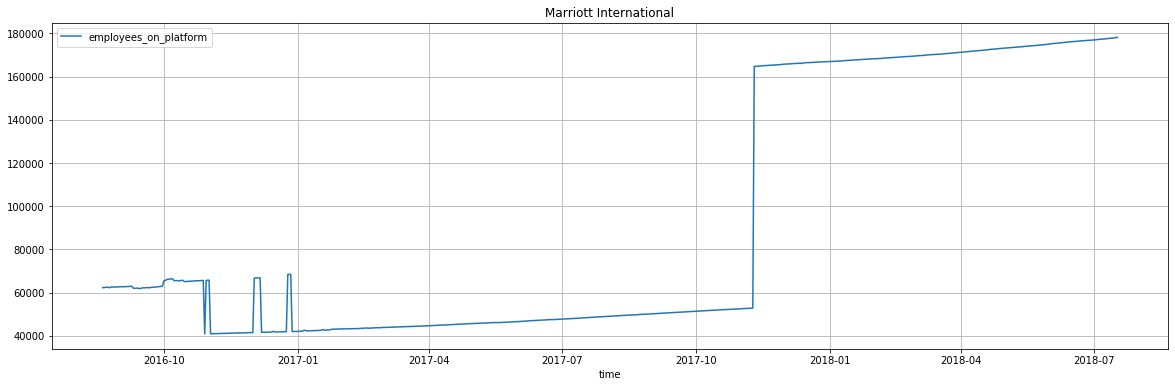

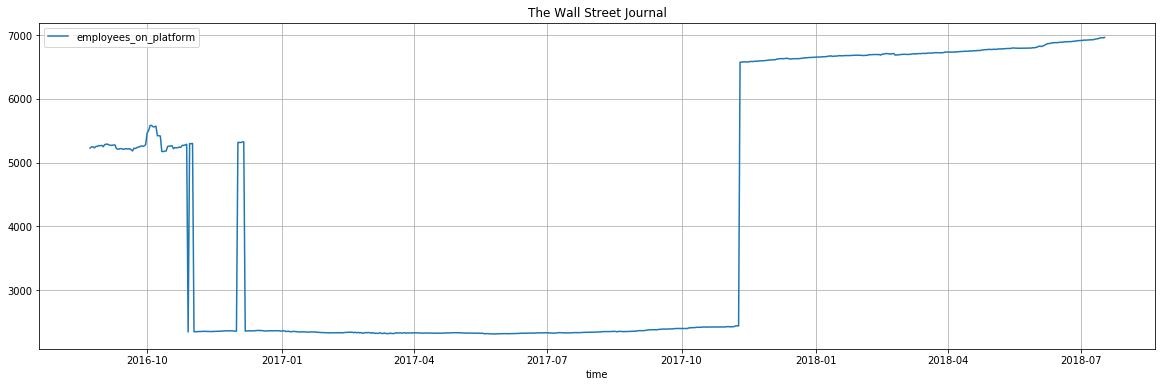

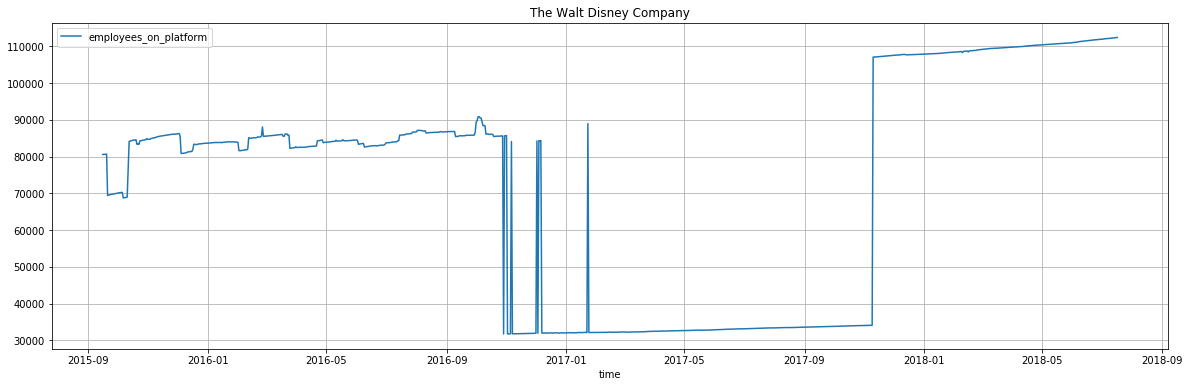

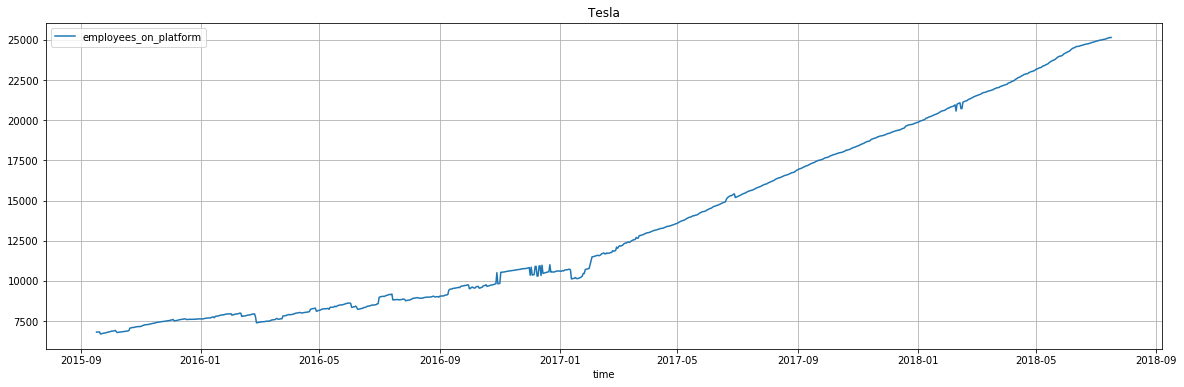

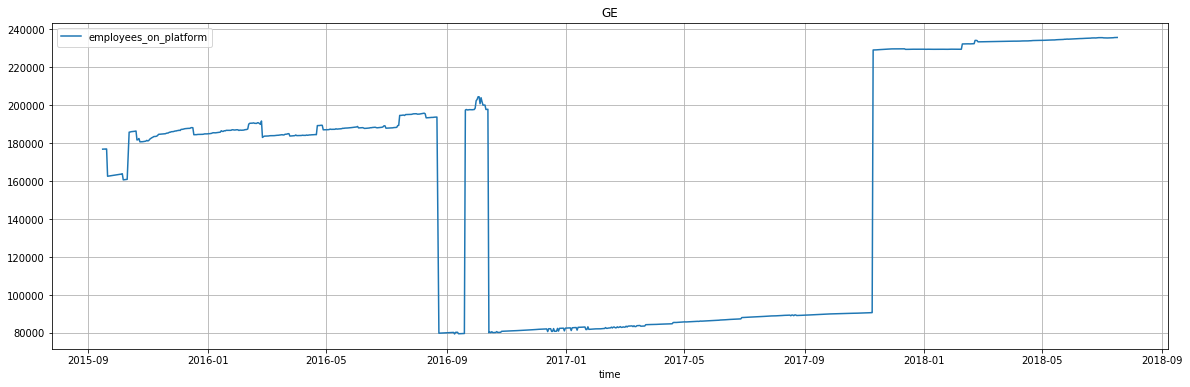

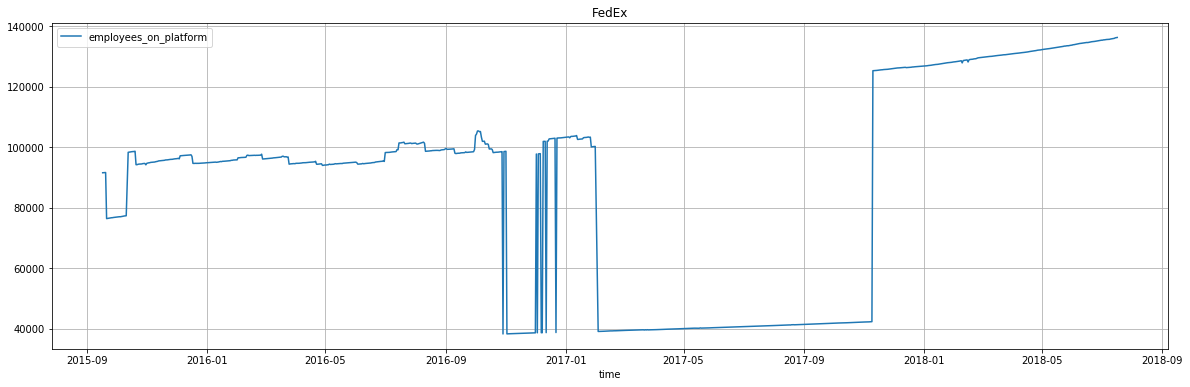

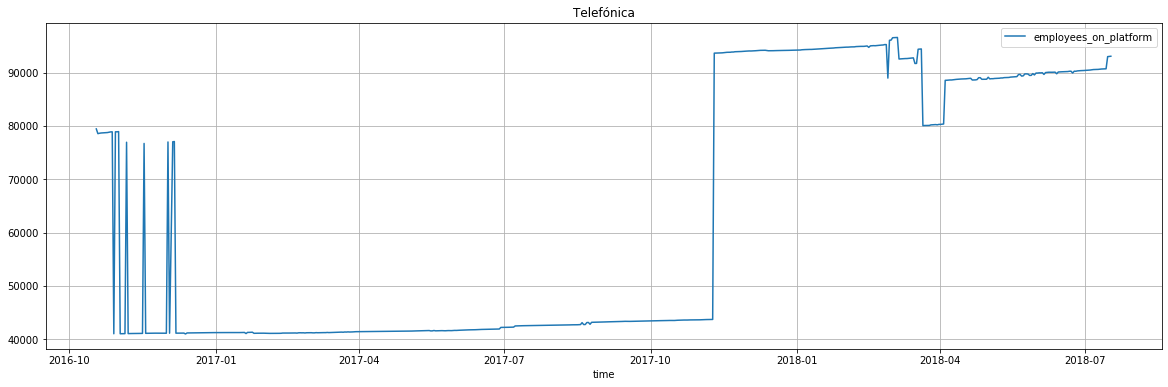

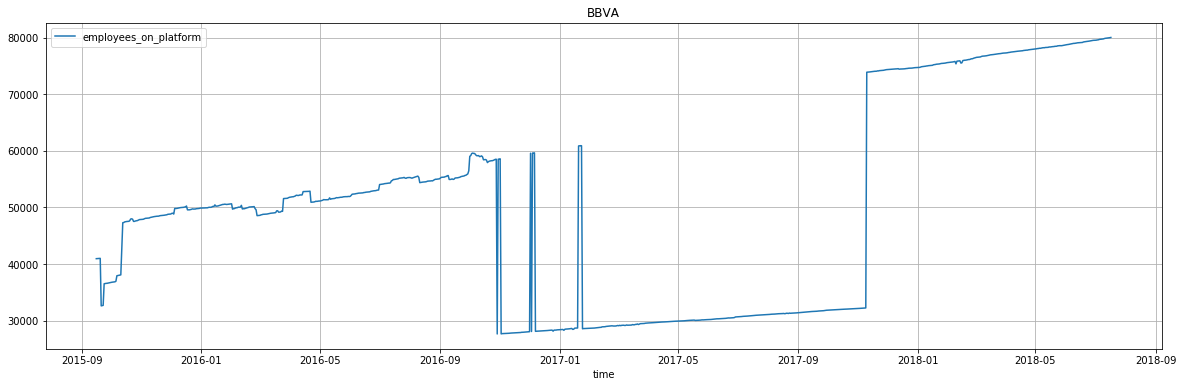

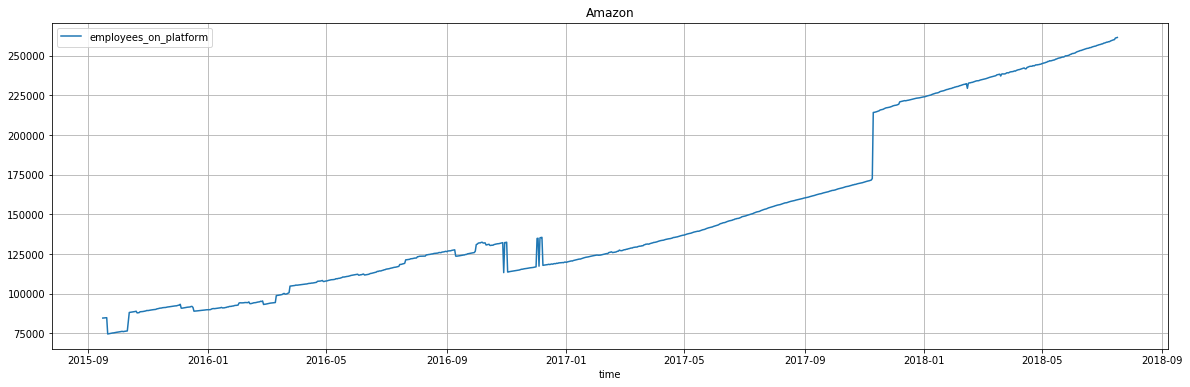

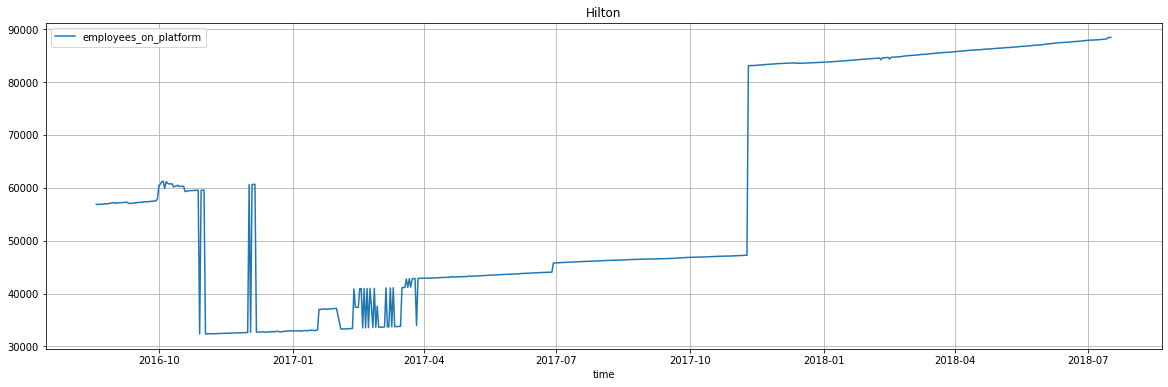

In [21]:
for dataset_id in company_reduce.iloc[:10]['dataset_id']:
    plot_e(dataset_id)

In [22]:
# bottom 10 companies in 'normalized_employees_on_platform_std'
company_reduce.sort_values(by='normalized_employees_on_platform_std', inplace = True)
print("top 10 companies in 'normalized_employees_on_platform_std'")
company_reduce.head(10)

top 10 companies in 'normalized_employees_on_platform_std'


,dataset_id,company,followers_count_mean,normalized_followers_count_std,employees_on_platform_mean,normalized_employees_on_platform_std
4125,2099831,HP,2531136,0.000156,58153,0.000774
4606,2339190,BRF,588768,0.005758,26446,0.002166
4576,2334960,Vale,638102,0.030509,42494,0.005343
3387,1337994,Nokia,656538,0.061060,163611,0.016138
4351,2255503,Tata Consultancy Services,1497581,0.051291,350963,0.017416
857,868192,Thomson Reuters,1157493,0.046228,60238,0.020179
3414,1339694,ABB,1004976,0.078781,90534,0.026474
11,58383,Cisco,1401677,0.153994,84843,0.036099
1088,869256,Weatherford,572681,0.055816,30243,0.036925
353,58725,Xerox,667983,0.057252,61039,0.040354


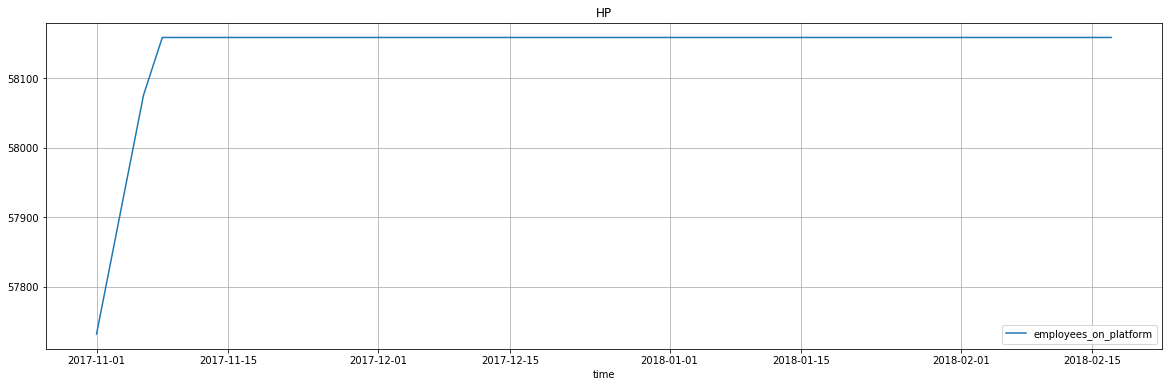

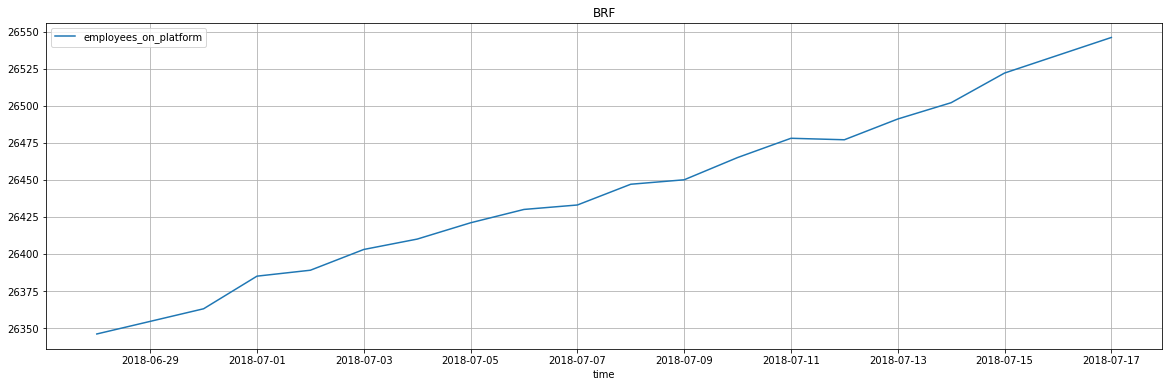

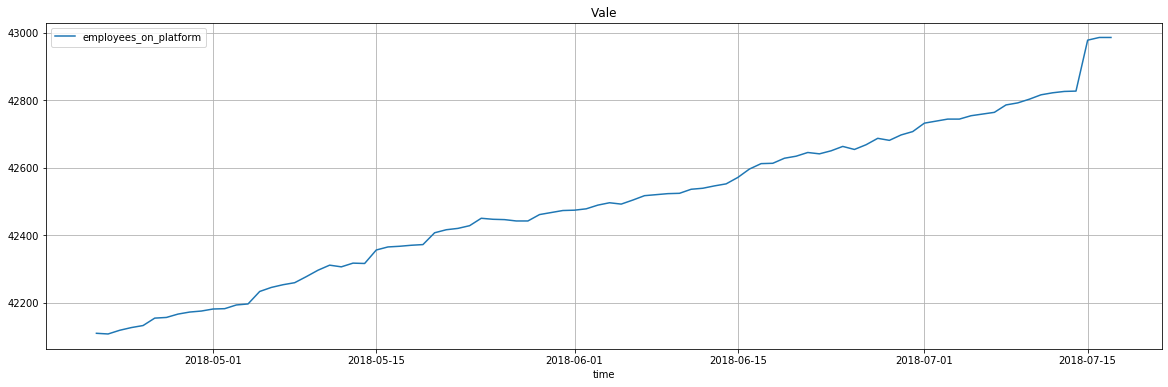

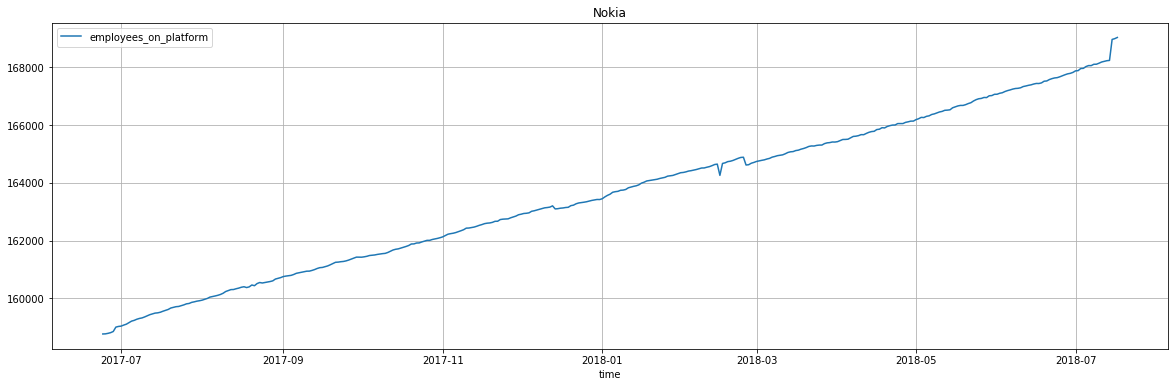

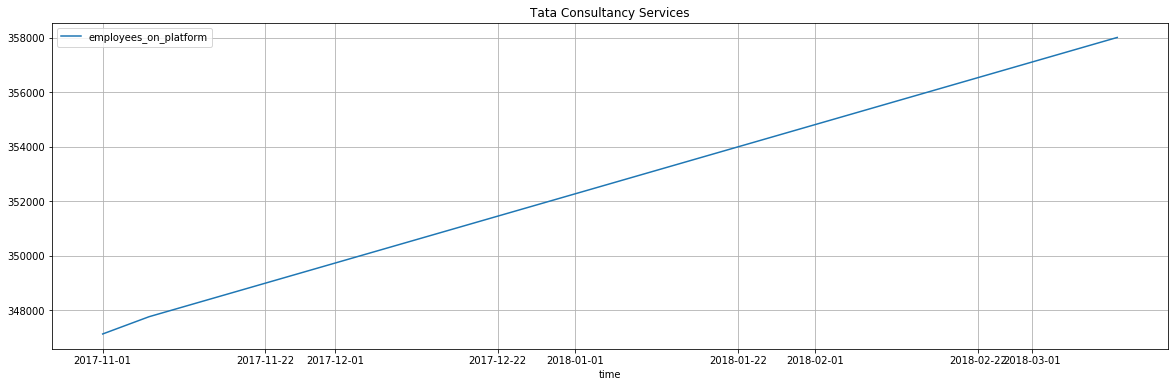

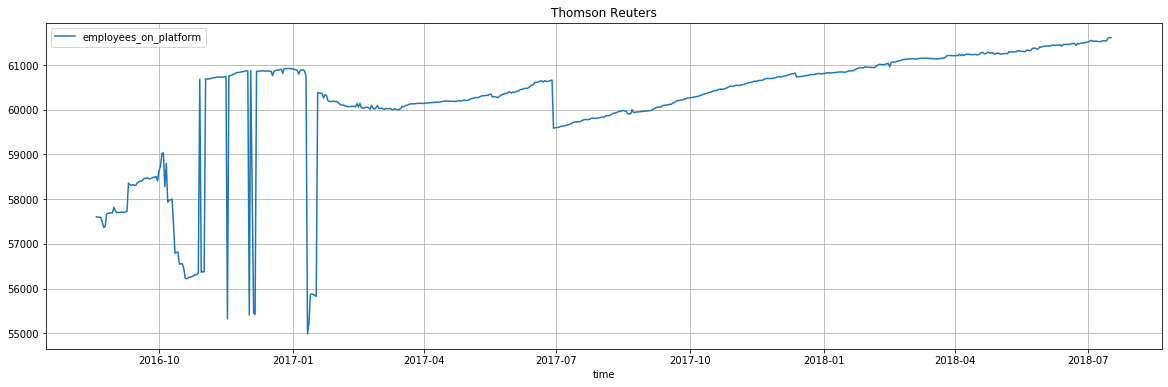

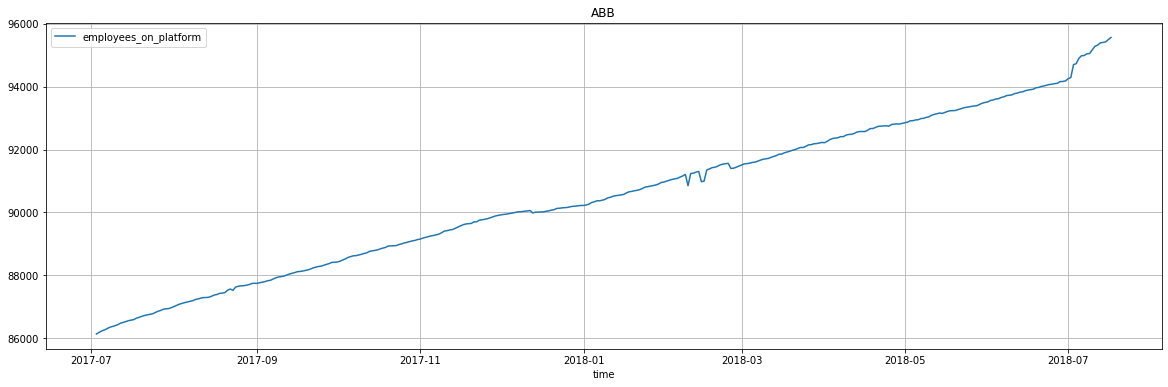

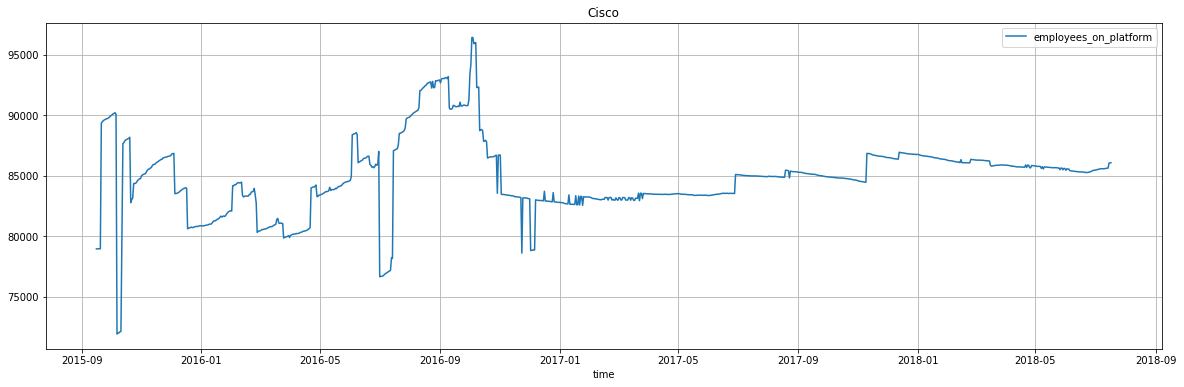

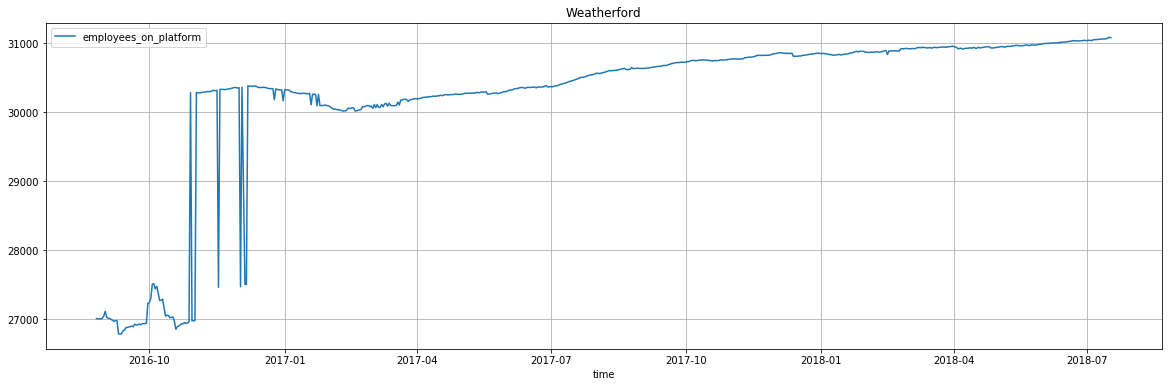

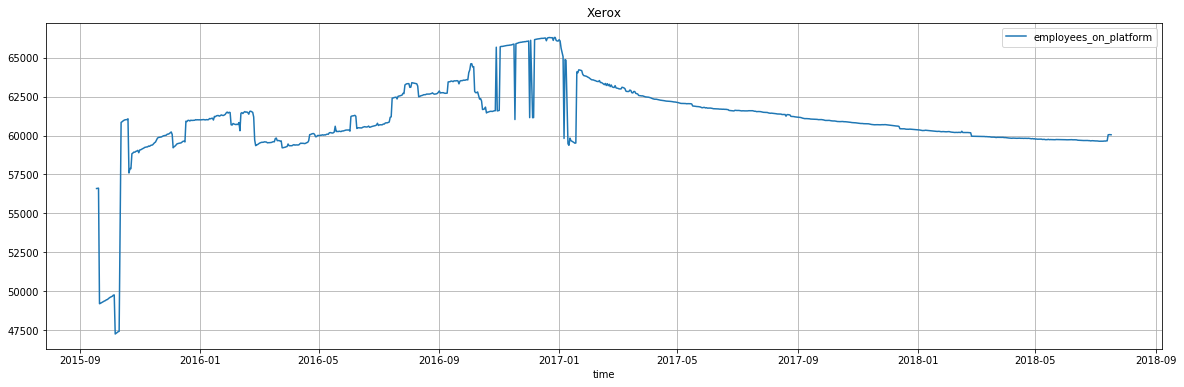

In [23]:
for dataset_id in company_reduce.iloc[:10]['dataset_id']:
    plot_e(dataset_id)